Treating layer(s) 8 incoherently
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...


/Users/phoebe/Documents/develop/solcore5/.mesonpy/editable/install/opt/homebrew/opt/python@3.10/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/solcore/analytic_solar_cells/depletion_approximation.py:617: RuntimeWarning: invalid value encountered in divide
  iqe =  j_sc / current_absorbed


Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


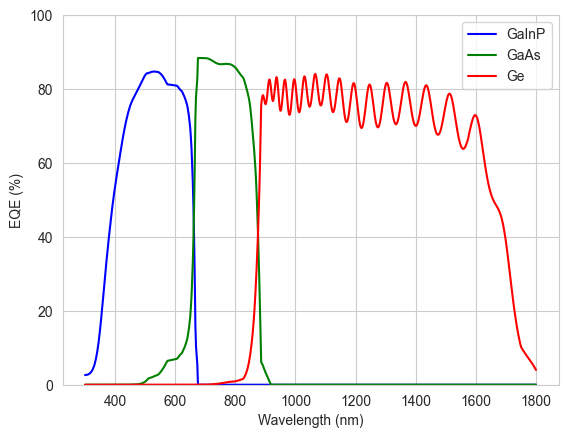

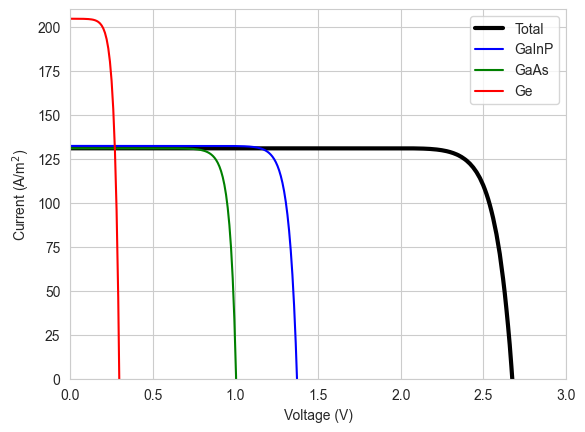

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from solcore import siUnits, material, si
from solcore.solar_cell import SolarCell
from solcore.structure import Junction, Layer
from solcore.solar_cell_solver import solar_cell_solver

all_materials = []

# We need to build the solar cell layer by layer.
# We start from the AR coating

MgF2 = material("MgF2")()
ZnS = material("ZnScub")()

ARC_layers = [Layer(si("100nm"), material=MgF2),
              Layer(si("50nm"), material=ZnS)]

# TOP CELL - GaInP
# Now we build the top cell, which requires the n and p sides of GaInP and a window layer.
# We also load the absorption coefficient from an external file. We also add some extra parameters needed for the
# calculation such as the minority carriers diffusion lengths
AlInP = material("AlInP")
InGaP = material("GaInP")
window_material = AlInP(Al=0.52)
top_cell_n_material = InGaP(In=0.49, Nd=siUnits(2e18, "cm-3"), hole_diffusion_length=si("200nm"))
top_cell_p_material = InGaP(In=0.49, Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("1um"))

all_materials.append(window_material)
all_materials.append(top_cell_n_material)
all_materials.append(top_cell_p_material)

# MID CELL  - GaAs
# We add manually the absorption coefficient of GaAs since the one contained in the database doesn't cover
# enough range, keeping in mind that the data has to be provided as a function that takes wavelengths (m) as input and
# returns absorption (1/m)
GaAs = material("GaAs")

mid_cell_n_material = GaAs(In=0.01, Nd=siUnits(3e18, "cm-3"), hole_diffusion_length=si("500nm"))
mid_cell_p_material = GaAs(In=0.01, Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("5um"))

all_materials.append(mid_cell_n_material)
all_materials.append(mid_cell_p_material)

# BOTTOM CELL - Ge
# We add manually the absorption coefficient of Ge since the one contained in the database doesn't cover
# enough range.
Ge = material("Ge")

bot_cell_n_material = Ge(Nd=siUnits(2e18, "cm-3"), hole_diffusion_length=si("800nm"))
bot_cell_p_material = Ge(Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("50um"))

all_materials.append(bot_cell_n_material)
all_materials.append(bot_cell_p_material)

# We add some other properties to the materials, assumed the same in all cases, for simplicity.
# If different, we should have added them above in the definition of the materials.
for mat in all_materials:
    mat.hole_mobility = 5e-2
    mat.electron_mobility = 3.4e-3
    mat.hole_mobility = 3.4e-3
    mat.electron_mobility = 5e-2
    mat.relative_permittivity = 9

# And, finally, we put everything together, adding also the surface recombination velocities. We also add some shading
# due to the metallisation of the cell = 8%, and indicate it has an area of 0.7x0.7 mm2 (converted to m2)
solar_cell = SolarCell(
        ARC_layers +
        [
        Junction([Layer(si("25nm"), material=window_material, role='window'),
                  Layer(si("100nm"), material=top_cell_n_material, role='emitter'),
                  Layer(si("600nm"), material=top_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA'),
        Junction([Layer(si("200nm"), material=mid_cell_n_material, role='emitter'),
                  Layer(si("3000nm"), material=mid_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA'),
        Junction([Layer(si("400nm"), material=bot_cell_n_material, role='emitter'),
                  Layer(si("100um"), material=bot_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA')
            ],
        shading=0.08, cell_area=0.7 * 0.7 / 1e4)

wl = np.linspace(300, 1800, 700) * 1e-9
solar_cell_solver(solar_cell, 'qe', user_options={'wavelength': wl, 'optics_method': 'TMM'})

plt.figure(1)
plt.plot(wl * 1e9, solar_cell[0 + len(ARC_layers)].eqe(wl) * 100, 'b', label='GaInP')
plt.plot(wl * 1e9, solar_cell[1 + len(ARC_layers)].eqe(wl) * 100, 'g', label='GaAs')
plt.plot(wl * 1e9, solar_cell[2 + len(ARC_layers)].eqe(wl) * 100, 'r', label='Ge')

plt.legend()
plt.ylim(0, 100)
plt.ylabel('EQE (%)')
plt.xlabel('Wavelength (nm)')

V = np.linspace(0, 3, 300)
solar_cell_solver(solar_cell, 'iv', user_options={'voltages': V, 'light_iv': True, 'wavelength': wl, 'optics_method': 'TMM'})

plt.figure(2)
plt.plot(V, solar_cell.iv['IV'][1], 'k', linewidth=3, label='Total')
plt.plot(V, -solar_cell[0 + len(ARC_layers)].iv(V), 'b', label='GaInP')
plt.plot(V, -solar_cell[1 + len(ARC_layers)].iv(V), 'g', label='GaAs')
plt.plot(V, -solar_cell[2 + len(ARC_layers)].iv(V), 'r', label='Ge')

plt.legend()
plt.ylim(0, 210)
plt.xlim(0, 3)
plt.ylabel('Current (A/m$^2$)')
plt.xlabel('Voltage (V)')

plt.show()